# Web Research (STORM)

`STORM` is a research assistant designed by Shao, et. al that extends the idea of "outline-driven RAG" for richer article generation.  
STORM is designed to generate Wikipedia-style ariticles on a user-provided topic. It applies two main insights to produce more organized and comprehensive articles:

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
%%capture --no-stderr
%pip install -U langchain_community langchain_openai langchain_fireworks langgraph wikipedia duckduckgo-search tavily-python

# Select LLM model

In [3]:
from langchain_openai import ChatOpenAI

fast_llm = ChatOpenAI(model_name="gpt-4o-mini")
long_context_llm = ChatOpenAI(model_name="gpt-4o")


In [4]:
from typing import List,Optional
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        
     (
        "system",
        "You are a Wikipedia writer. Write an outline for a Wikipedia page about a user-provided topic. Be comprehensive and specific.",
     ),
     ("user", "{topic}"),   
    ]
)
class Subsection(BaseModel):
    subsection_title: str = Field(..., title='Title of the subsection')
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f'###{self.subsection_title}\n\n{self.description}'.strip()
    
class Section(BaseModel):
    section_title: str = Field(..., title='Title of the section')
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title='Titles and descriptions for each subsection of the Wikipeida page.'
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"###{subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"##{self.section_title}\n\n{self.description}\n\n{subsections}".strip()
    
class Outline(BaseModel):
    page_title: str = Field(..., title='Title of the Wikipedia page')
    sections: List[Section] = Field(
        default_factory=list,
        title='Titles and descriptions for each section of the Wikipedia page.',
    )
    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()
    
generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(Outline)

In [5]:
example_topic = "Fine-tune LLM model LLama3.1  and create a Kazakh language model which can generate answers in Kazakh language"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})
print(initial_outline.as_str)

# Kazakh Language Model Using Llama 3.1

##Introduction

This section introduces the Kazakh language model based on Llama 3.1, explaining the purpose and significance of creating a specialized model for generating text in the Kazakh language.

###What is Llama 3.1?

An overview of Llama 3.1, its architecture, and capabilities.

###Importance of Kazakh Language Processing

Discusses the need for Kazakh language models in AI and technology, including historical and cultural relevance.

##Methodology

This section outlines the process of fine-tuning the Llama 3.1 model specifically for the Kazakh language.

###Data Collection

Details on the datasets used for training, including sources of Kazakh texts and data preparation methods.

###Training Process

A description of the technical specifications of the fine-tuning process, including hardware used, parameters tuned, and training duration.

###Evaluation Metrics

Explanation of the metrics used to evaluate the model's performance in gene

# Expand Topics

In [6]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentioned below. \
    Please identify and recommend some Wikipedia pages on closely related subjects. \
    I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, \
    or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics. \
    Please list the as many subjects and urls as you can.   \
    Topic of interest: {topic}
"""
)

class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )

expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(RelatedSubjects)

In [7]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})


In [8]:
related_subjects.model_dump()

{'topics': ['Large Language Models',
  'Fine-tuning of Machine Learning Models',
  'Natural Language Processing',
  'Kazakh Language',
  'Artificial Intelligence',
  'LLM Training Techniques',
  'Language Model Evaluation',
  'Multilingual Models',
  'OpenAI GPT Models',
  'Transformers in AI',
  'Hugging Face',
  'BERT',
  'GPT-3',
  'Machine Learning for Minority Languages',
  'Cultural Significance of Language Models',
  'NLP for Kazakh',
  'Machine Translation']}

# Generate Perspectives

In [9]:
class Editor(BaseModel):
    affilation: str = Field(
        description="Primary affilation of the editor.",
    )
    name: str = Field(
        description="Name of the editor.",
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffilation: {self.affilation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    editors: List[Editor]= Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )
gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You need to select a diverse (and distinct) group of Wikipedia editors who will work together to create a comprehensive article on the topic.\
                Each of them represents a different perspective, role, or affiliation related to this topic.\
            You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on.\
            Wiki page outlines of related topics for inspiration: {examples}""",
        ),
        ("user", "Topic of interest: {topic}")
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | ChatOpenAI(model_name="gpt-4o-mini").with_structured_output(Perspectives)



In [10]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)

def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata['categories'])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[:max_length]

def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)

@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})


In [11]:
perspectives = await survey_subjects.ainvoke(example_topic)
perspectives.model_dump()

/opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


{'editors': [{'affilation': 'Global AI Research Lab',
   'name': 'Aizhan Mukhtar',
   'role': 'AI Researcher',
   'description': 'Aizhan will focus on the nuances of the Kazakh language and its specific linguistic features. They will compile a comprehensive dataset for fine-tuning the LLM, ensuring it captures the unique grammatical structures and vocabulary prevalent in Kazakh.'},
  {'affilation': 'Kazakh National University',
   'name': 'Serik Baidykov',
   'role': 'Linguist',
   'description': "Serik will provide insights on Kazakh semantics, syntax, and phonetics. His contributions will be crucial in refining the model's understanding of cultural context and idiomatic expressions relevant to the Kazakh-speaking population."},
  {'affilation': 'Hugging Face',
   'name': 'Julia Zheng',
   'role': 'ML Engineer',
   'description': 'Julia will supervise the technical aspects of fine-tuning the Llama 3.1 model, ensuring efficient training processes are followed. She will also implement n

# Expert Dialog

## Interview State

In [12]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

def add_message(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right

def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references

def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor

class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_message]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]


## Dialog Roles

In [13]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import MessagesPlaceholder

gen_qn_prompt = ChatPromptTemplate.from_messages(
        [
            (
    "system",
            """You are an experienced Wikipedia writer and want to edit a specific page. \
            Besides your identity as a Wikipedia writer, you have a specific focus when researching the topic. \
            Now, you are chatting with an expert to get information. Ask good questions to get more useful information.  \
            When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.\
            Please only ask one question at a time and don't ask what you have asked before.\
            Your questions should be related to the topic you want to write.
            Be comprehensive and curious, gaining as much unique insight from the expert as possible.\
            Stay true to your specific perspective: {persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
        ]
    )

def tag_with_name(ai_message: AIMessage, name: str):
    valid_name = ''.join(c for c in name if c.isalnum() or c in ['_', '-'])
    ai_message.name = valid_name
    return ai_message

def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state['messages']:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.model_dump(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}

@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}

In [14]:
messages = [
    HumanMessage(f"So you said you were writing an article on {example_topic}?")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)
question["messages"][0].content

'I’m actually focusing on the linguistic features of Kazakh to enhance the fine-tuning of LLM models like Llama 3.1. Can you share what specific grammatical structures and vocabulary are particularly challenging when working with the Kazakh language?'

In [15]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions.",
    )
gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful research assistant. Query the search engine to answer the user's questions.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | ChatOpenAI(
    model_name="gpt-4o-mini"
).with_structured_output(Queries, include_raw=True)

In [16]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries['parsed'].queries

['Kazakh language grammatical structures',
 'difficulties in Kazakh grammar',
 'Kazakh vocabulary challenges for LLMs',
 'Kazakh sentence structure complexity',
 'Kazakh agglutination and its effects on LLMs',
 'issues in fine-tuning LLMs with Kazakh data',
 'common linguistic features of Kazakh',
 'Kazakh language morphology and syntax',
 'specific Kazakh idioms and phrases',
 'Kazakh language nuances in machine learning',
 'popular Kazakh language resources',
 'Kazakh dialectal variations',
 'challenges of Kazakh language translation',
 'Kazakh verb conjugation rules',
 'Kazakh grammatical cases and their uses']

In [17]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer",
    )
    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )
gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert who can use information effectively. You are chatting with a Wikipedia writer who wants\
                to write a Wikipedia page on the topic you know. You have gathered the related information and will now use the information to form a response.\
            Make your response as informative as possible and make sure every sentence is supported by the gathered information.\
Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLS after your response.""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [18]:
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool

tavily_search = TavilySearchResults(max_results=4)

@tool
async def search_engine(query: str) -> str:
    """Search engine to the internet."""
    results = tavily_search.invoke(query)
    return [{"content": r["content"], "url": r["url"]} for r in results]


# search_engine = DuckDuckGoSearchAPIWrapper()

# @tool
# async def search_engine(query: str) -> str:
#     """Search engine to the internet."""
#     results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
#     return [{"content": r["body"], "url": r['href']} for r in results]

In [19]:
import json
from langchain_core.runnables import RunnableConfig
async def gen_answer(
        state: InterviewState,
        config: Optional[RunnableConfig] = None,
        name: str = "Subject_Matter_Expert",
        max_str_len: int = 15000,
):
    valid_name = ''.join(c for c in name if c.isalnum() or c in ['_', '-'])
    swapped_state = swap_roles(state, valid_name) # Convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries['parsed'].queries, config, return_exceptions=True
    )
    successfull_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res['url']: res['content'] for results in successfull_results for res in results
    }

    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries["raw"]
    
    # Check if tool_calls is not empty
    if ai_message.tool_calls:
        tool_call = ai_message.tool_calls[0]
        tool_id = tool_call["id"]
        tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
        swapped_state["messages"].extend([ai_message, tool_message])
    else:
        # Handle the case where tool_calls is empty
        print("Warning: No tool calls found in the AI message.")
        return {"messages": [ai_message], "references": {}}

    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return {"messages": [formatted_message], "references": cited_references}

In [20]:
example_answer  = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

'{"queries":["Kazakh language grammatical structures","challenges in Kazakh morphology","Kazakh syntax complexities","Kazakh vocabulary difficulties for LLMs","Kazakh language unique features for model training","common grammatical errors in Kazakh","Kazakh language fine-tuning techniques","language model challenges with agglutinative languages","lease context of verb conjugation in Kazakh","Kazakh noun cases and declensions","Kazakh language sentence structure","Kazakh vocabulary richness and idioms","Kazakh language linguistic diversity","Llama models fine-tuning with Kazakh language specifics","best practices for Kazakh LLM training"]}'

In [21]:
example_answer

{'messages': [AIMessage(content='{"queries":["Kazakh language grammatical structures","challenges in Kazakh morphology","Kazakh syntax complexities","Kazakh vocabulary difficulties for LLMs","Kazakh language unique features for model training","common grammatical errors in Kazakh","Kazakh language fine-tuning techniques","language model challenges with agglutinative languages","lease context of verb conjugation in Kazakh","Kazakh noun cases and declensions","Kazakh language sentence structure","Kazakh vocabulary richness and idioms","Kazakh language linguistic diversity","Llama models fine-tuning with Kazakh language specifics","best practices for Kazakh LLM training"]}', additional_kwargs={'parsed': Queries(queries=['Kazakh language grammatical structures', 'challenges in Kazakh morphology', 'Kazakh syntax complexities', 'Kazakh vocabulary difficulties for LLMs', 'Kazakh language unique features for model training', 'common grammatical errors in Kazakh', 'Kazakh language fine-tuning t

## Construct the Interview Graph

In [22]:
max_num_turns = 5
from langgraph.pregel import RetryPolicy

def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"

builder = StateGraph(InterviewState)
builder.add_node("ask_question", generate_question, retry=RetryPolicy(max_attempts=5))
builder.add_node("answer_question", gen_answer, retry=RetryPolicy(max_attempts=5))
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")


builder.add_edge(START, "ask_question")
interview_graph = builder.compile(checkpointer=False).with_config(run_name="Conduct Interviews")

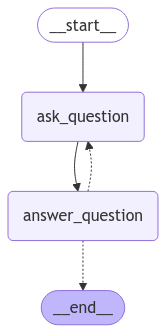

In [23]:
from IPython.display import Image, display
try:
    display(Image(interview_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [24]:
final_step = None
initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"So you said you were writing an article on {example_topic}?",
            name="Subject_Matter_Expert",
        )
    ],

}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("--", str(step[name]['messages'])[:300])
final_step = step

ask_question
-- [AIMessage(content="Yes, that's correct. I'm particularly interested in the specific linguistic features of the Kazakh language, including its grammar, vocabulary, and syntax, that I need to consider while fine-tuning the LLM. Could you explain the key grammatical structures in Kazakh that are cruci
answer_question
-- [AIMessage(content='{"queries":["Kazakh language grammatical structures","Kazakh syntax rules","Key features of Kazakh grammar","Kazakh language vocabulary characteristics","Fine-tuning language models for Kazakh","Kazakh language morphology and syntax","Understanding Kazakh sentence structure","Bas
ask_question
-- [AIMessage(content='Could you elaborate on the basic grammatical principles in Kazakh, such as noun cases and verb conjugations, and how they might impact the generation of coherent text by an LLM?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'pr
answer_question
-- [AIMessage(content='{"queri

CancelledError: 

In [25]:
final_step = step

In [26]:
final_state = next(iter(final_step.values()))


# Refine Outline

In [27]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Wikipedia writer. You have gathered information from experts and search engines. \
                Now, you are refining the outline of the Wikipedia page. \
                You need to make sure that the outline is comprehensive and specific. \
                Topic you are writing about: {topic} \
                Old outline: {old_outline}""",
        ),
        (
            "user",
            "Refine the outline based on your conversations with subject-matter experts:\n\nConversations:\n\n{conversations}\n\nWrite the refined Wikipedia outline:",
        ),
        
    ]
)
# Using turbo preview since the context can get quite long
refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(Outline)

In [28]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str,
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"]
        ),
    }
)

In [29]:
print(refined_outline.as_str)

# Fine-tuning the LLama 3.1 Model to Create a Kazakh Language Model

##Introduction

Introduction to the Kazakh Language Model development utilizing LLama 3.1 for generating accurate and fluent Kazakh language text.

###Overview of LLama 3.1

An explanation of the LLama 3.1 architecture, highlighting its advanced language processing capabilities.

###Significance in Kazakh Language Processing

An exploration of the cultural and linguistic importance of developing AI language models for Kazakh, given its unique language features and representation needs.

##Methodology

A comprehensive breakdown of the techniques and procedures employed to fine-tune the LLama 3.1 model specifically for the Kazakh language.

###Data Collection Strategy

Insights into the selection and preparation of high-quality Kazakh datasets, focusing on diverse language registers and sources.

###Fine-tuning Techniques

Technical details on parameter adjustments and the fine-tuning process tailored for the Kazakh lan

# Generate Article

In [ ]:
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
reference_docs = [
    Document(page_content=v, metadata={"source":k})
    for k, v in final_state['references'].items()
]
# This really doesn't need to be a vectorstore for this size of data.
# It could just be a numpy matrix. Or you could store documents
# across  requests if you want.
vectorstore = InMemoryVectorStore.from_documents(
    reference_docs,
    embeddings=embeddings
)
retriever = vectorstore.as_retriever(k=3)